# Reforumlated Markowitz Model - Optimization Codes through Quantum Computing

Import the necessary libraries

In [61]:
import numpy as np
import pandas as pd
from dimod import ConstrainedQuadraticModel, Integer, Binary
import time
from matplotlib import pyplot as plt

Importing the Data

In [3]:
df = pd.read_excel("Daily_Returns.xlsx")

Changing the Date to the index

In [4]:
# Convert the 'date' column to datetime format 
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'date' column as the index
df.set_index('Date', inplace=True)

Calculating the expected returns and the variance covariance matrix

In [5]:
# Calculate expected returns for each asset
expected_returns = np.mean(df,axis=0)*252

# Calculate the variance-covariance matrix
cov_matrix = df.cov()


#Converting the expected returns to a numpy array
expected_returns = expected_returns.values

#The number of assets
n_assets = len(expected_returns)

Setting the values of the constraints

In [6]:
# Maximum acceptable risk (R): The total risk that the portfolio can assume, based on variance-covariance matrix
R = 0.1

# Maximum units of each asset that can be purchased (D)
D = 5

# Maximum number of assets in the portfolio (K): The maximum number of different assets that can be included in the portfolio
K = 15

# The number of shares the investor would like to purchase
S = 20

Creating the Decision Variables

In [7]:
y = [Binary(f"y_{i}") for i in range(n_assets)] #To represent y

In [8]:
X = [Integer(f"x_{i}") for i in range(n_assets)] #To represent x

Finding the weights

In [9]:
W = [x/S for x in X] 

Create the CQM Object

In [10]:
cqm = ConstrainedQuadraticModel()

Creating the Objective Function

In [11]:
H_obj = 0
for i in range(n_assets):
    H_obj -= expected_returns[i] * W[i]

Creating the risk constraint

In [12]:
# Convert the Variance Covariance matrix to a NumPy array
cov_matrix_np = cov_matrix.to_numpy()

# Convert X to a NumPy array
W_numeric = np.array(W)  

# Calculate the total variance
total_variance = np.dot(W_numeric.T, np.dot(cov_matrix_np, W_numeric))

Setting the Objective Function

In [13]:
cqm.set_objective(H_obj)

Setting the Risk Constraint

In [14]:
cqm.add_constraint_from_model(total_variance, '<=', R**2, "Variance", weight=1)

'Variance'

Adding the Linking Constraints

In [15]:
# Diversification Constraints
for i in range(n_assets):
    cqm.add_constraint_from_model(X[i] - D*y[i], '<=', 0, label=f"Linking_{i}", weight=1)

Adding the cardinality constraint

In [16]:
cqm.add_constraint_from_model(sum(y), '<=', K, label="Cardinality", weight=1)

'Cardinality'

Adding the constraint on the number of shares

In [17]:
cqm.add_constraint_from_model(sum(X), '==', S, label="Total Shares", weight=1)

'Total Shares'

Solving the optimization problem

In [18]:
from dwave.system import LeapHybridCQMSampler
sampler = LeapHybridCQMSampler(token="DEV-df309da97162b976954c423a5c0df694bc7b7bdf")  

In [19]:
#Solve the problem
sampleset = sampler.sample_cqm(cqm)

In [20]:
print(sampleset.first) 

Sample(sample={'x_0': 0.0, 'x_1': 5.0, 'x_10': 0.0, 'x_100': 0.0, 'x_101': 0.0, 'x_102': 0.0, 'x_103': 0.0, 'x_104': 0.0, 'x_105': 0.0, 'x_106': 0.0, 'x_107': 0.0, 'x_108': 0.0, 'x_109': 0.0, 'x_11': 0.0, 'x_110': 0.0, 'x_111': 0.0, 'x_112': 0.0, 'x_113': 0.0, 'x_114': 0.0, 'x_115': 0.0, 'x_116': 0.0, 'x_117': 0.0, 'x_118': 0.0, 'x_119': 0.0, 'x_12': 0.0, 'x_120': 0.0, 'x_121': 0.0, 'x_122': 0.0, 'x_123': 0.0, 'x_124': 0.0, 'x_125': 0.0, 'x_126': 0.0, 'x_127': 0.0, 'x_128': 0.0, 'x_129': 0.0, 'x_13': 0.0, 'x_130': 0.0, 'x_131': 0.0, 'x_132': 0.0, 'x_133': 0.0, 'x_134': 0.0, 'x_135': 0.0, 'x_136': 0.0, 'x_137': 0.0, 'x_138': 0.0, 'x_139': 0.0, 'x_14': 0.0, 'x_140': 0.0, 'x_141': 0.0, 'x_142': 0.0, 'x_143': 0.0, 'x_144': 0.0, 'x_15': 0.0, 'x_16': 0.0, 'x_17': 0.0, 'x_18': 0.0, 'x_19': 0.0, 'x_2': 0.0, 'x_20': 0.0, 'x_21': 0.0, 'x_22': 0.0, 'x_23': 0.0, 'x_24': 0.0, 'x_25': 0.0, 'x_26': 0.0, 'x_27': 0.0, 'x_28': 0.0, 'x_29': 0.0, 'x_3': 0.0, 'x_30': 0.0, 'x_31': 0.0, 'x_32': 5.0, 'x_33': 

Checking for the violation of constraints

In [21]:
for label, violation in cqm.iter_violations(sampleset.first[0], skip_satisfied=True):
    print(label, violation)

Recreating the original decision variables

In [22]:
sample = sampleset.first[0]

# Number of decision variables
num_decision_variables = n_assets

# Reconstruct the original decision variables
decision_variables = []
for i in range(num_decision_variables):
    decision_variables.append(sample[f'x_{i}'])

decision_variables


[0.0,
 5.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

Calculating the Return

In [23]:
# Find the weights
result = [x / S for x in decision_variables]


# Multiply corresponding elements and sum them up
total = sum(x * y for x, y in zip(expected_returns, result))

print(total)

0.20186450006434886


Now let us test to see if all the constraints are satisfied

In [24]:
# Extract y values from sample
y_optimized = np.array([sample[f'y_{i}'] for i in range(n_assets)])

# Convert decision_variables to a numpy array for easy manipulation
x_optimized = np.array(decision_variables)
w_optimized = np.array(result)

# Now, checking the constraints with these values
# Constraint 1: Risk constraint
risk_value = np.sqrt(np.dot(np.dot(w_optimized.T, cov_matrix), w_optimized))
print(f"Risk Constraint Satisfied: {risk_value <= R}")
print(f"Risk Value: {risk_value} <= {R}")

# Constraint 2: Linking constraint
diversification_values = x_optimized <= D * y_optimized
print(f"Linking Constraints Satisfied: {all(diversification_values)}")

# Constraint 3: Cardinality constraint
cardinality_value = (x_optimized > 0).sum()
print(f"Cardinality Constraint Satisfied: {cardinality_value <= K}")
print(f"Number of Assets Included: {cardinality_value} <= {K}")

# Constraint 4: Non-negativity constraint
non_negativity_satisfied = all(x_optimized >= 0)
print(f"Non-negativity Constraints Satisfied: {non_negativity_satisfied}")


# Constraint 5: Sum of units
unit_sum = sum(x_optimized)
print(f"Sum of units Constraint Satisfied: {unit_sum <= S}")
print(f"Number of units Included: {unit_sum} <= {S}")


Risk Constraint Satisfied: True
Risk Value: 0.014684182951557738 <= 0.1
Linking Constraints Satisfied: True
Cardinality Constraint Satisfied: True
Number of Assets Included: 4 <= 15
Non-negativity Constraints Satisfied: True
Sum of units Constraint Satisfied: True
Number of units Included: 20.0 <= 20


Checking the assets to invest in

In [25]:
values_list = x_optimized.tolist()

# Creating a new DataFrame with column names and values where values are > 0
filtered_data = {'Asset': [], 'Value': []}
for column_name, value in zip(df.columns, values_list):
    if value > 0:
        filtered_data['Asset'].append(column_name)
        filtered_data['Value'].append(value)

new_df = pd.DataFrame(filtered_data)

print(new_df)

  Asset  Value
0  AAPL    5.0
1   ARE    5.0
2  BIIB    5.0
3   CHD    5.0


Calculating the portfolio with the highest returns

In [59]:
#Sum of shares
S = 1000

X = [Integer(f"x_{i}") for i in range(n_assets)] #To represent x
W = [x/S for x in X] #For the weight

H_obj = 0
for i in range(n_assets):
    H_obj -= expected_returns[i] * W[i]

# Create the CQM Object
cqm = ConstrainedQuadraticModel()

#Adding the objective function
cqm.set_objective(H_obj)


#Adding the sum of shares constraint
cqm.add_constraint_from_model(sum(X), '==', S, label="Total Shares", weight=5)

#Solve the problem
sampleset = sampler.sample_cqm(cqm)

#Checking for violations
for label, violation in cqm.iter_violations(sampleset.first[0], skip_satisfied=True):
    print(label, violation)

#Recreating the original variables
sample = sampleset.first[0]

# Number of decision variables
num_decision_variables = n_assets

# Reconstruct the original decision variables
decision_variables = []
for i in range(num_decision_variables):
    decision_variables.append(sample[f'x_{i}'])

#Calculating the total return

# Find the weights
weights = [x / S for x in decision_variables]

# Multiply corresponding elements and sum them up
total = sum(x * y for x, y in zip(expected_returns, weights))

# Convert decision_variables to a numpy array for easy manipulation
x_optimized_max_return = np.array(decision_variables)

# Convert weights to a numpy array for easy manipulation
w_optimized_max_return = np.array(weights)

# Risk Value
risk_value_maximum_return = np.sqrt(np.dot(np.dot(w_optimized_max_return.T, cov_matrix), w_optimized_max_return))

print("The number of units to buy: ")
print(x_optimized_max_return)
print("SUM OF WEIGHTS:",sum(w_optimized_max_return))
print("Risk: ", risk_value_maximum_return)
print("Return: ", total)

The number of units to buy: 
[ 2.  8.  3.  7.  4. 14.  4.  7.  2.  7. 10. 13.  1. 11.  6.  0.  1. 12.
  4. 22.  1. 10.  2.  4.  8.  3.  0.  0.  3.  9. 11.  9.  1.  3.  4.  1.
  3.  1.  9.  0. 11.  0. 10.  9.  6.  0.  9. 15.  5.  1.  1.  6. 12. 10.
 21. 24. 15.  8. 12. 12. 11.  6.  2.  6.  0.  1.  9.  0.  8.  8.  0.  0.
  0.  6. 24. 21.  7. 13.  6.  1.  1.  4.  5. 19. 15.  1.  0. 14.  0.  8.
  2.  5.  5.  2. 15. 15.  7.  4.  8. 10.  3.  1.  2.  0.  4.  2.  5.  5.
 12.  0. 20. 13.  5.  3.  2.  0.  4.  1.  8.  7.  5.  1. 13.  0.  8.  0.
  1. 20.  0.  8. 15.  7. 29.  3.  9.  8.  7.  0. 34. 14.  1. 15.  6. 10.
 13.]
SUM OF WEIGHTS: 1.0000000000000007
Risk:  0.011417779924015797
Return:  0.16256428555818447


Calculating the portolio with the lowest risk

In [60]:
#Sum of shares
S = 1000


X = [Integer(f"x_{i}") for i in range(n_assets)] #To represent x
W = [x/S for x in X] #For the weight


# Convert the Variance Covariance matrix to a NumPy array
cov_matrix_np = cov_matrix.to_numpy()

# Convert X to a NumPy array
W_numeric = np.array(W)  

# Calculate the total variance
total_variance = np.dot(W_numeric.T, np.dot(cov_matrix_np, W_numeric))

# Create the CQM Object
cqm = ConstrainedQuadraticModel()

#Adding the objective function
cqm.set_objective(total_variance)


#Adding the sum of shares constraint
cqm.add_constraint_from_model(sum(X), '==', S, label="Total Shares", weight=1)

#Solve the problem
sampleset = sampler.sample_cqm(cqm)



#Checking for violations
for label, violation in cqm.iter_violations(sampleset.first[0], skip_satisfied=True):
    print(label, violation)



#Recreating the original variables
sample = sampleset.first[0]

# Number of decision variables
num_decision_variables = n_assets

# Reconstruct the original decision variables
decision_variables = []
for i in range(num_decision_variables):
    decision_variables.append(sample[f'x_{i}'])




#Calculating the total return

# Find the weights
weights = [x / S for x in decision_variables]


# Multiply corresponding elements and sum them up
total = sum(x * y for x, y in zip(expected_returns, weights))

# Convert decision_variables to a numpy array for easy manipulation
x_optimized_MIN_RISK = np.array(decision_variables)

# Convert weights to a numpy array for easy manipulation
w_optimized_MIN_RISK = np.array(weights)

# Risk Value
risk_value_minimum = np.sqrt(np.dot(np.dot(w_optimized_MIN_RISK.T, cov_matrix), w_optimized_MIN_RISK))


print("The number of units to buy: ")
print(x_optimized_MIN_RISK)
print("SUM OF WEIGHTS:",sum(w_optimized_MIN_RISK))
print("Risk: ", risk_value_minimum)
print("Return: ", total)

The number of units to buy: 
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 999.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.]
SUM OF WEIGHTS: 1.0
Risk:  0.009727443177069054
Return:  0.03555056117475771


Calculating the efficient frontier

In [92]:
# Initialize arrays to store portfolio returns, volatilities, and weights
num_ports = 50

# Calculate the gap between portfolio volatilities for equally spaced portfolios
vol_min = risk_value_minimum
vol_max = risk_value_maximum_return
gap = (vol_max - vol_min) / (num_ports)

# Maximum acceptable risk (R): The total risk that the portfolio can assume, based on variance-covariance matrix
Variance_Values = [(vol_min + gap*i) for i in range(num_ports)]


In [93]:
"""

We will now loop over multiple risk values to calculate the return and get an efficient frontier and generate
each of the portfolios for these risk values. Note that all the constraints except the number of shares and the investor should invest
in and the risk value would be relaxed in this solution for the purpose of comparing with the vanilla markowitz model.

"""

results_list = []  # Initialize the list

for R in Variance_Values:

    # Check the variance value
    print(R)

    # Create the CQM Object
    cqm = ConstrainedQuadraticModel()

    #Adding the objective function
    cqm.set_objective(H_obj)


    # Add risk constraints
    cqm.add_constraint_from_model(total_variance, '>=' ,(R)**2, label="Min Risk",weight=1)
    cqm.add_constraint_from_model(total_variance, '<=' ,(R)**2, label="Max Risk",weight=1)

    
    #Adding the sum of shares constraint
    cqm.add_constraint_from_model(sum(X), '==', S, label="Total Shares", weight=1)


    # Time the sampler
    start_time = time.time()
    sampleset = sampler.sample_cqm(cqm)
    time_taken = time.time() - start_time


    #Checking for violations
    for label, violation in cqm.iter_violations(sampleset.first[0], skip_satisfied=True):
        print(label, violation)


    #Recreating the original variables
    sample = sampleset.first[0]

    # Number of decision variables
    num_decision_variables = n_assets

    # Reconstruct the original decision variables
    decision_variables = []
    for i in range(num_decision_variables):
        decision_variables.append(sample[f'x_{i}'])


    #Calculating the total return

    # Find the weights
    weights = [x / S for x in decision_variables]


    # Multiply corresponding elements and sum them up
    total = sum(x * y for x, y in zip(expected_returns, weights))

    # Convert decision_variables to a numpy array for easy manipulation
    x_optimized = np.array(decision_variables)

    # Convert weights to a numpy array for easy manipulation
    w_optimized = np.array(weights)

    # Constraint 1: Risk constraint
    risk_value = np.sqrt(np.dot(np.dot(w_optimized.T, cov_matrix), w_optimized))

    # Constraint 2: Non-negativity constraint
    non_negativity_satisfied = all(x_optimized >= 0)

    # Constraint 3: Sum of shares constraint
    sum_of_shares_satisfied = sum(x_optimized) == S

    #Creating the asset dataframe
    values_list = x_optimized.tolist()

    # Creating a new DataFrame with column names and values where values are > 0
    filtered_data = {'Asset': [], 'Value': []}
    for column_name, value in zip(df.columns, values_list):
        if value > 0:
            filtered_data['Asset'].append(column_name)
            filtered_data['Value'].append(value)

    # Create a dictionary for the current iteration
    iteration_results = {
        'time_taken': time_taken,
        'risk_value': risk_value,
        'R': R,
        'total_return': total,
        'risk_constraint_satisfied': risk_value <= R,
        'non_negativity_satisfied': non_negativity_satisfied,
        'Total_Shares_satisfied': sum_of_shares_satisfied,
        'assets_included_df': filtered_data
    }

    # Step 4: Append this dictionary to the list
    results_list.append(iteration_results)

0.009727443177069054
Max Risk 0.00045206612102016464
0.00976124991200799
Max Risk 0.0004976210853082001
0.009795056646946925
Max Risk 0.0013037489264069377
0.009828863381885858
Max Risk 0.0006087404874123302
0.009862670116824793
Max Risk 0.0007660258744288528
0.009896476851763729
Max Risk 0.0003132580362968856
0.009930283586702664
Max Risk 0.00017302745060230655
0.009964090321641599
Max Risk 0.0002321904508095389
0.009997897056580534
Max Risk 0.00046352604975026686
0.010031703791519467
Max Risk 0.0005384385448789894
0.010065510526458403
Max Risk 0.001298448879234928
0.010099317261397338
Max Risk 0.0010338043783595333
0.010133123996336273
Max Risk 0.00041485619292386223
0.010166930731275208
Max Risk 0.0007599316557676133
0.010200737466214142
Max Risk 0.0007474834792295593
0.010234544201153077
Max Risk 0.0007585522412568056
0.010268350936092012
Max Risk 0.0003411070989841011
0.010302157671030947
Max Risk 0.0005068055804073717
0.010335964405969882
Max Risk 0.00046647189641169654
0.0103697

Creating a dataframe of results

In [94]:
# Creating a DataFrame from results_list for specific metrics
metrics_columns = [
    'time_taken',
    'risk_value',
    'R',
    'total_return',
    'risk_constraint_satisfied',
    'non_negativity_satisfied',
    'Total_Shares_satisfied'
]

# Use a list comprehension to pick out these specific keys from each dictionary in the results list
final_results_data = [{col: result[col] for col in metrics_columns} for result in results_list]

# Convert this list of dictionaries to a DataFrame
final_results_df = pd.DataFrame(final_results_data)

# Save the DataFrame as an Excel file
final_results_df.to_excel('Final_Results.xlsx', index=False)


Plotting the efficient frontier

In [97]:
#Calculating the sharpe ratio
final_results_df["Sharpe_Ratio"]=final_results_df["total_return"]/final_results_df["R"]

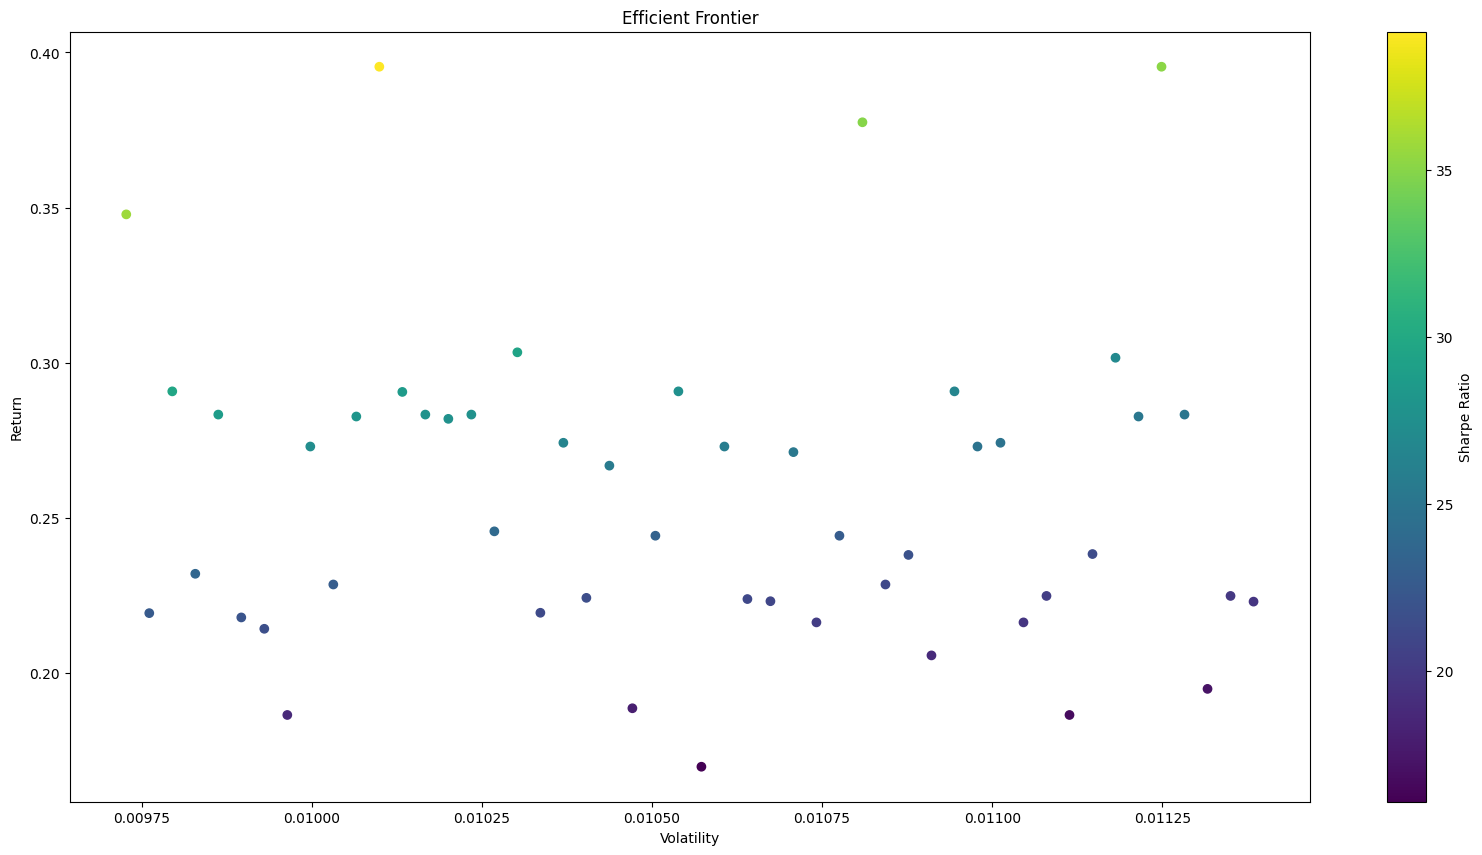

In [98]:

# Plotting the Efficient Frontier
plt.figure(figsize=(20, 10))
plt.scatter(final_results_df["R"], final_results_df["total_return"], c=final_results_df["Sharpe_Ratio"], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()


Creating the excels of Asset Allocations

In [86]:
for i, result in enumerate(results_list, start=1):
    # Convert filtered_data (which replaced new_df) to a DataFrame
    assets_df = pd.DataFrame(result['assets_included_df'])
    
    # Save the DataFrame as an Excel file
    file_name = f'Assets{i}.xlsx'
    assets_df.to_excel(file_name, index=False)